# Introduction of Trading with Momentum

### Load necessary packages

In [1]:
%matplotlib inline
import os
import random
import pandas_datareader.data as web
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from ipywidgets import interact, fixed, IntSlider
import matplotlib.pyplot as plt
from numpy.linalg import cholesky
import seaborn as sns

### Load Data from yahoo finance

In [2]:
cached_data={}
def stock_hist(symbol, start=None, end=None, cached_data=cached_data):
    if not symbol in cached_data:
        cached_data[symbol]=yf.download(symbol)
        print(F'Loaded {symbol} num values = {len(cached_data[symbol])}')
    return cached_data[symbol]

In [3]:
tickers=['MSFT', 'AMZN', 'AAPL', 'TSLA' ]
N = len(tickers)
historical = pd.concat((stock_hist(symbol)['Adj Close'] for symbol in tickers), axis=1, keys=tickers).dropna(axis=0)

[*********************100%***********************]  1 of 1 completed
Loaded MSFT num values = 8737
[*********************100%***********************]  1 of 1 completed
Loaded AMZN num values = 5911
[*********************100%***********************]  1 of 1 completed
Loaded AAPL num values = 10062
[*********************100%***********************]  1 of 1 completed
Loaded TSLA num values = 2610


### Resample Data

#### Resample Adjusted Prices
The trading signal does not need to be based on daily prices, for instance, you can use month-end prices to perform trading once a month. To do this, you must first resample the daily adjusted closing prices into monthly buckets, and select the last observation of each month.

In [4]:
def resample_prices(close_prices, freq='M'):
    """
    Resample close prices for each ticker at specified frequency.
    
    Parameters
    ----------
    close_prices : DataFrame
        Close prices for each ticker and date
    freq : str
        What frequency to sample at
        For valid freq choices, see http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
    
    Returns
    -------
    prices_resampled : DataFrame
        Resampled prices for each ticker and date
    """
    # TODO: Implement Function
    
    close_prices.resample(freq).last()
    
    return close_prices.resample(freq).last()


In [5]:
historical_monthly_close = resample_prices(historical)

In [6]:
historical_monthly_close.head()

,MSFT,AMZN,AAPL,TSLA
Date,,,,
2010-06-30,18.133703,109.260002,7.762749,4.766
2010-07-31,20.340328,117.889999,7.939281,3.988
2010-08-31,18.594894,124.830002,7.502583,3.896
2010-09-30,19.403025,157.059998,8.757125,4.082
2010-10-31,21.130194,165.229996,9.288879,4.368


## Compute Log Returns

Compute log returns ($R_t$) from prices ($P_t$) as your primary momentum indicator:

$$R_t = log_e(P_t) - log_e(P_{t-1})$$

The `compute_log_returns` function below accepts a dataframe and produces a similar dataframe of log returns.

In [18]:
def compute_log_returns(prices):
    """
    Compute log returns for each ticker.
    
    Parameters
    ----------
    prices : DataFrame
        Prices for each ticker and date
    
    Returns
    -------
    log_returns : DataFrame
        Log returns for each ticker and date
    """
    
    log_returns = np.log(prices) - np.log(prices.shift(1))
    
    return log_returns

In [19]:
monthly_close_returns = compute_log_returns(historical_monthly_close)

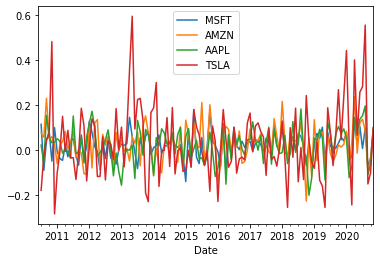

In [20]:
monthly_close_returns.plot()

## Shift Returns
Function to shift the log returns to the previous or future returns in the time series.

In [21]:
def shift_returns(returns, shift_n):
    """
    Generate shifted returns
    
    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    shift_n : int
        Number of periods to move, can be positive or negative
    
    Returns
    -------
    shifted_returns : DataFrame
        Shifted returns for each ticker and date
    """
    
    return returns.shift(shift_n)

In [25]:
prev_returns = shift_returns(monthly_close_returns, 1)
lookahead_returns = shift_returns(monthly_close_returns, -1)

## Generate Trading Signal

A trading signal is a sequence of trading actions, or results that can be used to take trading actions. A common form is to produce a "long" and "short" portfolio of stocks on each date (e.g. end of each month, or whatever frequency you desire to trade at). This signal can be interpreted as rebalancing your portfolio on each of those dates, entering long ("buy") and short ("sell") positions as indicated.

Strategy:
> For each month-end observation period, rank the stocks by _previous_ returns, from the highest to the lowest. Select the top performing stocks for the long portfolio, and the bottom performing stocks for the short portfolio.

The `get_top_n` function get the top performing stock for each month. Get the top performing stocks from `prev_returns` by assigning them a value of 1. For all other stocks, give them a value of 0. For example, using the following `prev_returns`:

```
                                     Previous Returns
               A         B         C         D         E         F         G
2013-07-08     0.015     0.082     0.096     0.020     0.075     0.043     0.074
2013-07-09     0.037     0.095     0.027     0.063     0.024     0.086     0.025
...            ...       ...       ...       ...       ...       ...       ...
```

The function `get_top_n` with `top_n` set to 3 should return the following:
```
                                     Previous Returns
               A         B         C         D         E         F         G
2013-07-08     0         1         1         0         1         0         0
2013-07-09     0         1         0         1         0         1         0
...            ...       ...       ...       ...       ...       ...       ...
```

In [24]:
def get_top_n(prev_returns, top_n):
    """
    Select the top performing stocks
    
    Parameters
    ----------
    prev_returns : DataFrame
        Previous shifted returns for each ticker and date
    top_n : int
        The number of top performing stocks to get
    
    Returns
    -------
    top_stocks : DataFrame
        Top stocks for each ticker and date marked with a 1
    """
    
    # Creating a zero-filled pandas data frame
    topPerfBi = pd.DataFrame(0, index=prev_returns.index, columns=prev_returns.columns)
    
    for index, row in prev_returns.iterrows():
        top_performers = row.nlargest(top_n).index
        topPerfBi.loc[index, top_performers] = 1
    
    return topPerfBi


### View Data
Get the best performing and worst performing stocks. To get the best performing stocks, we use the `get_top_n` function. To get the worst performing stocks, we also use the `get_top_n` function. However, we pass in `-1*prev_returns` instead of just `prev_returns`. Multiplying by negative one will flip all the positive returns to negative and negative returns to positive. Thus, it will return the worst performing stocks.

In [31]:
top_bottom_n = 2
df_long = get_top_n(prev_returns, top_bottom_n)
df_short = get_top_n(-1*prev_returns, top_bottom_n)

In [33]:
def print_top(df, name, top_n=2):
    print('{} Most {}:'.format(top_n, name))
    print(', '.join(df.sum().sort_values(ascending=False).index[:top_n].values.tolist()))

In [34]:
print_top(df_long, 'Longed Stocks')
print_top(df_short, 'Shorted Stocks')

2 Most Longed Stocks:
AMZN, TSLA
2 Most Shorted Stocks:
MSFT, AAPL


## Projected Returns
It's now time to check if the trading signal has the potential to become profitable!

We'll start by computing the net returns this portfolio would return. For simplicity, we'll assume every stock gets an equal dollar amount of investment. This makes it easier to compute a portfolio's returns as the simple arithmetic average of the individual stock returns.

The `portfolio_returns` function compute the expected portfolio returns. Using `df_long` to indicate which stocks to long and `df_short` to indicate which stocks to short, calculate the returns using `lookahead_returns`. To help with calculation, with `n_stocks` as the number of stocks we're investing in a single period.

In [41]:
def portfolio_returns(df_long, df_short, lookahead_returns, n_stocks):
    """
    Compute expected returns for the portfolio, assuming equal investment in each long/short stock.
    
    Parameters
    ----------
    df_long : DataFrame
        Top stocks for each ticker and date marked with a 1
    df_short : DataFrame
        Bottom stocks for each ticker and date marked with a 1
    lookahead_returns : DataFrame
        Lookahead returns for each ticker and date
    n_stocks: int
        The number number of stocks chosen for each month
    
    Returns
    -------
    portfolio_returns : DataFrame
        Expected portfolio returns for each ticker and date
    """
    
    
    portfolio_returns = df_long - df_short
    portfolio_returns = 1 * portfolio_returns * lookahead_returns / n_stocks
    
    return portfolio_returns

In [42]:
expected_portfolio_returns = portfolio_returns(df_long, df_short, lookahead_returns, 2*top_bottom_n)

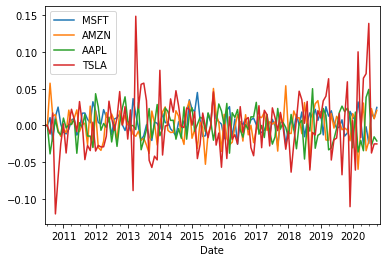

In [43]:
expected_portfolio_returns.plot()

### Statistical Test

#### Annualized Rate of Return

In [44]:
expected_portfolio_returns_by_date = expected_portfolio_returns.T.sum().dropna()
portfolio_ret_mean = expected_portfolio_returns_by_date.mean()
portfolio_ret_ste = expected_portfolio_returns_by_date.sem()
portfolio_ret_annual_rate = (np.exp(portfolio_ret_mean * 12) - 1) * 100

print("""
Mean:                       {:.6f}
Standard Error:             {:.6f}
Annualized Rate of Return:  {:.2f}%
""".format(portfolio_ret_mean, portfolio_ret_ste, portfolio_ret_annual_rate))


Mean:                       0.002141
Standard Error:             0.004013
Annualized Rate of Return:  2.60%



The annualized rate of return allows to compare the rate of return from this strategy to other quoted rates of return, which are usually quoted on an annual basis. 

### T-Test
The null hypothesis ($H_0$) is that the actual mean return from the signal is zero. We'll perform a one-sample, one-sided t-test on the observed mean return, to see if we can reject $H_0$.

First compute the t-statistic, and then find its corresponding p-value. The p-value will indicate the probability of observing a t-statistic equally or more extreme than the one we observed if the null hypothesis were true. A small p-value means that the chance of observing the t-statistic we observed under the null hypothesis is small, and thus casts doubt on the null hypothesis. It's good practice to set a desired level of significance or alpha ($\alpha$) _before_ computing the p-value, and then reject the null hypothesis if $p < \alpha$.

We use $\alpha = 0.05$, since it's a common value to use.

The `analyze_alpha` function performs a t-test on the sample of portfolio returns. We've imported the `scipy.stats` module to perform the t-test.

In [45]:
from scipy import stats

def analyze_alpha(expected_portfolio_returns_by_date):
    """
    Perform a t-test with the null hypothesis being that the expected mean return is zero.
    
    Parameters
    ----------
    expected_portfolio_returns_by_date : Pandas Series
        Expected portfolio returns for each date
    
    Returns
    -------
    t_value
        T-statistic from t-test
    p_value
        Corresponding p-value
    """
    
    zero_hypothesis = 0
    
    t_value, p_value = stats.ttest_1samp(expected_portfolio_returns_by_date, zero_hypothesis)

    return t_value, p_value/2

In [46]:
t_value, p_value = analyze_alpha(expected_portfolio_returns_by_date)
print("""
Alpha analysis:
 t-value:        {:.3f}
 p-value:        {:.6f}
""".format(t_value, p_value))


Alpha analysis:
 t-value:        0.533
 p-value:        0.297331



The observed p-value is 0.297331. It is higher than the defined  𝛼  of 0.05. The null hypothesis failed to be rejected. This means because we can't reject the null hypothesis which was that the actual mean return from the signal is zero, that our actual mean return from the signal could be zero.